# **EXPLORATORY TIME SERIES ANALYSIS TO GET INSIGHTS INTO THE DATA**

In [ ]:
!pip install stldecompose
!pip install pmdarima
!pip install shutup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv("btc_1h.csv")
df.shape

FileNotFoundError: [Errno 2] No such file or directory: 'btc_1h.csv'

In [ ]:
data = pd.read_csv("btc_1h.csv")
new = data.drop(['open', 'high', 'low', 'volume'], axis=1, inplace=False)
new['datetime'] = pd.to_datetime(new['datetime'])
new['datetime'] = new['datetime'] -  pd.Timedelta(minutes=30) # used so that we can compare with the date_range
new.set_index(new['datetime'], inplace=True)
new.drop(['datetime'], axis=1, inplace=True)

In [ ]:
print(f"Null values in dataframe = {data.isna().sum()}, Duplicated rows in dataframe = {data.duplicated().sum()}\n")

# While using the data to run time series models, it was found that the data was missing a few entries. We inserted the
# missing rows and filled in the data using linear interpolation.

print(pd.date_range(new.index.min(), new.index.max(), freq='H').difference(new.index))
new = new.resample('H').interpolate(method='time')

Null values in dataframe = datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64, Duplicated rows in dataframe = 0

DatetimeIndex(['2018-01-04 09:00:00', '2018-02-08 06:00:00',
               '2018-02-08 07:00:00', '2018-02-08 08:00:00',
               '2018-02-08 09:00:00', '2018-02-08 10:00:00',
               '2018-02-08 11:00:00', '2018-02-08 12:00:00',
               '2018-02-08 13:00:00', '2018-02-08 14:00:00',
               ...
               '2021-04-20 08:00:00', '2021-04-25 10:00:00',
               '2021-04-25 11:00:00', '2021-04-25 12:00:00',
               '2021-08-13 07:00:00', '2021-08-13 08:00:00',
               '2021-08-13 09:00:00', '2021-08-13 10:00:00',
               '2021-09-29 12:00:00', '2021-09-29 13:00:00'],
              dtype='datetime64[ns]', length=121, freq=None)


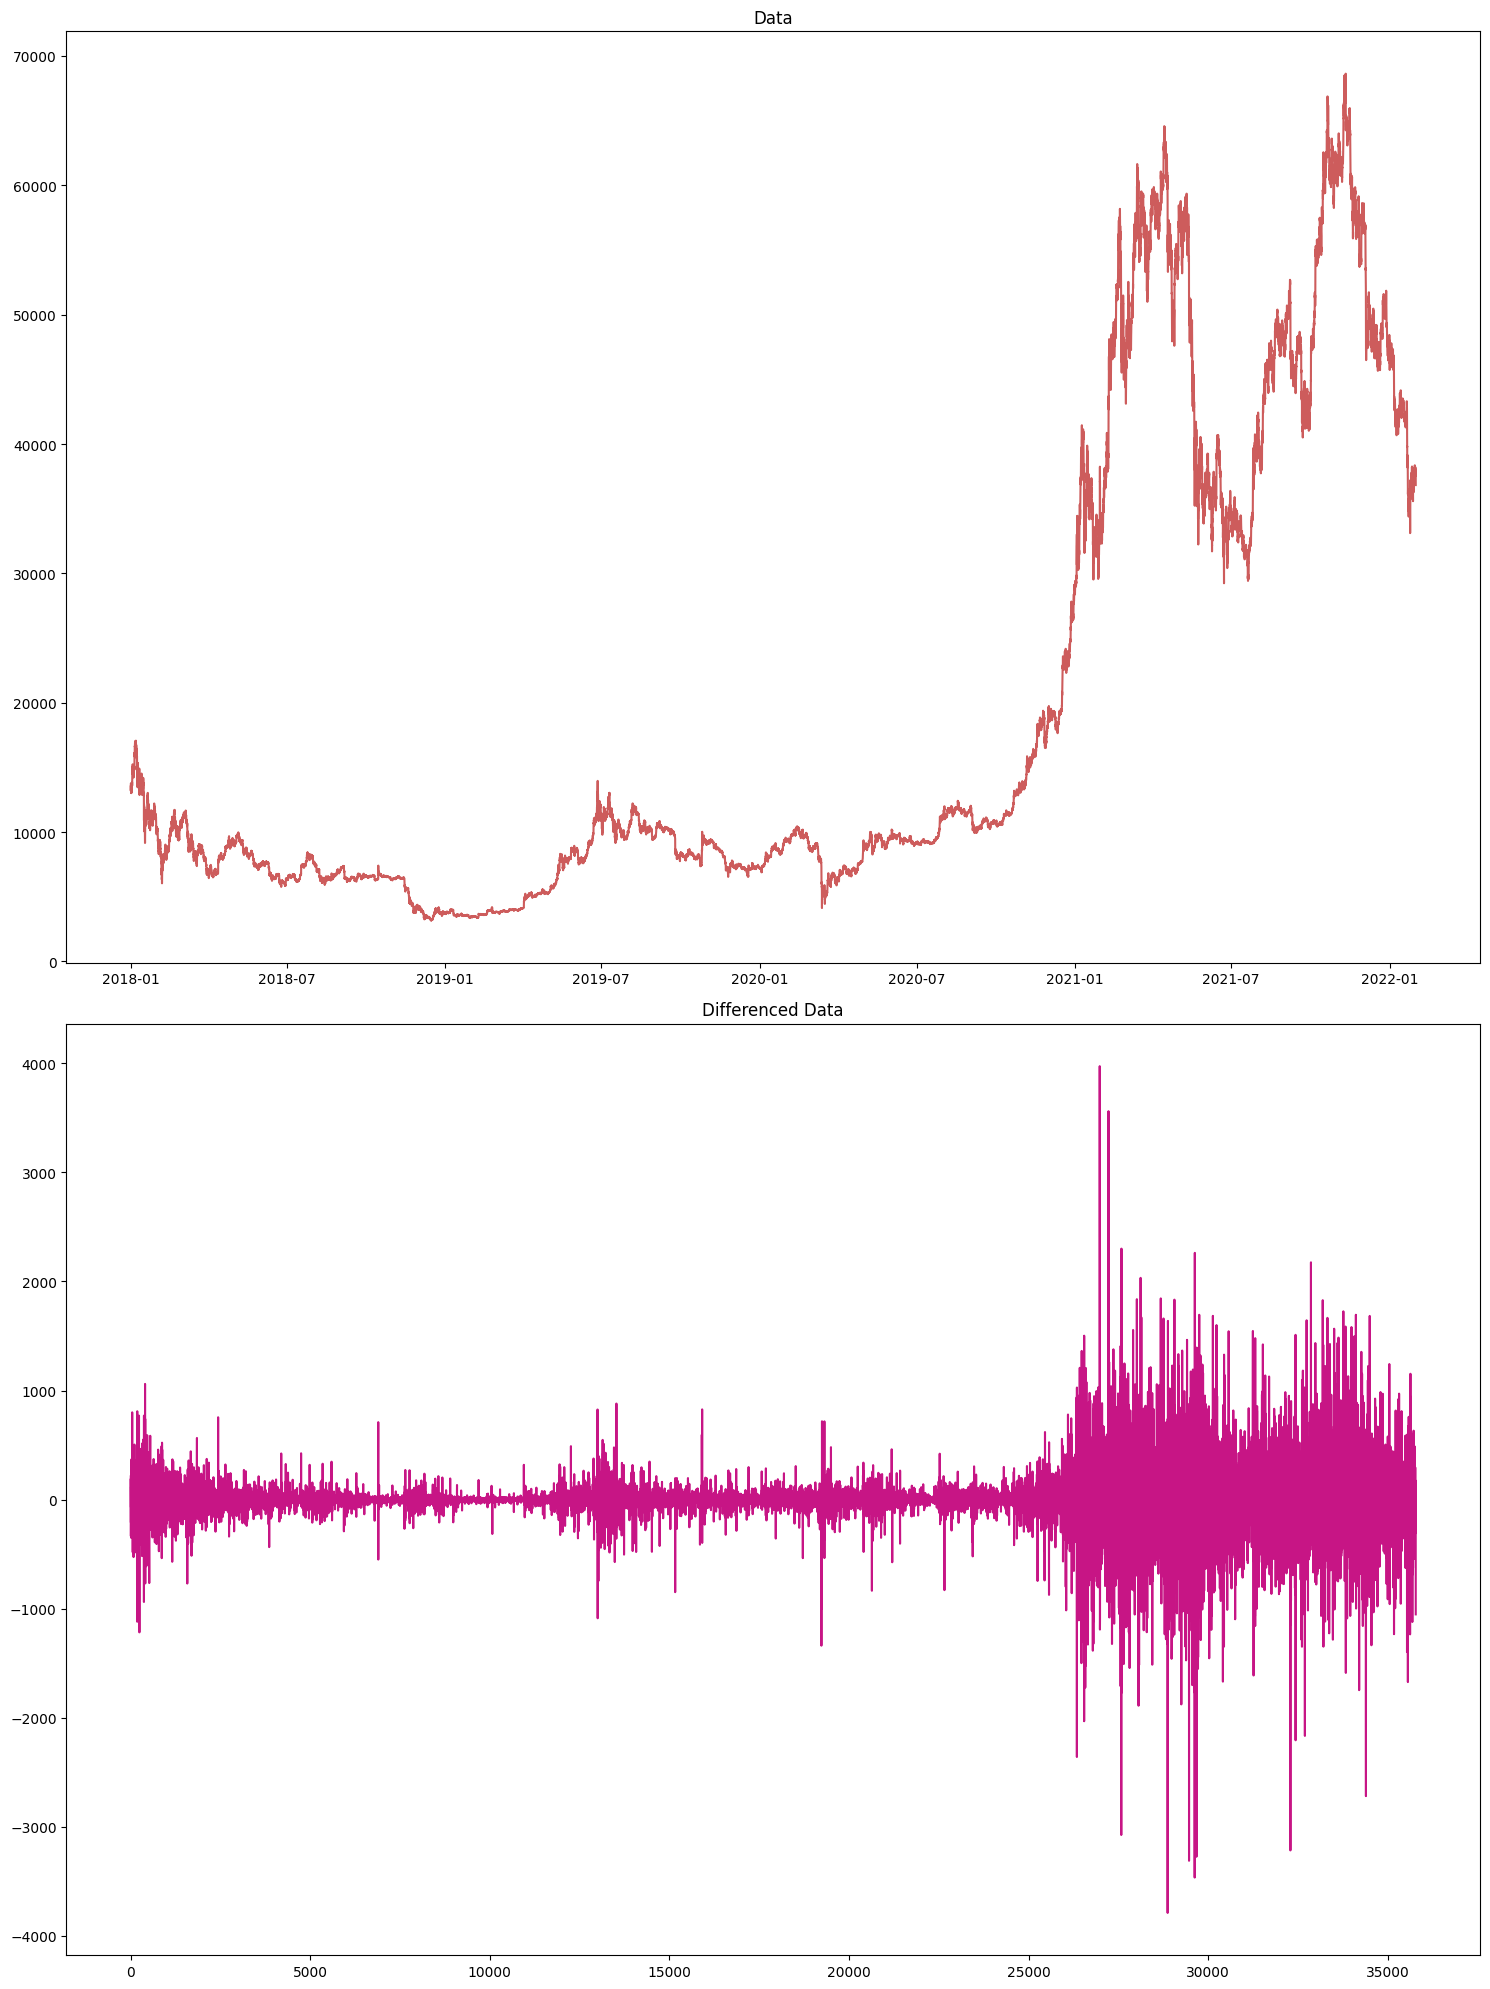

In [ ]:
# We need to generate stationary data, because most time series models
#use the assumption of stationarity of the data in order to develop many models.

fig, ax = plt.subplots(2, 1, figsize=(15, 20))
ax[0].plot(new['close'], color="indianred")
ax[0].set_title('Data')
# LOL, not at all stationary! There is a distinct trend after the first half,
# with slight seasonality (?) and increased variability so we take log transform
ax[1].plot(np.diff(new['close']), color="mediumvioletred")
ax[1].set_title('Differenced Data')

plt.savefig('Plots of data')
plt.tight_layout()

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
def test_stationarity(df):
    p = adfuller(df)[1]
    print(f"Data is not stationary" if p > 0.05 else f"Stationary data!")
    return p

In [ ]:
print(test_stationarity(new.close))
print(test_stationarity(np.diff(new.close)))

#Just to check how less the p-value for the difference is:
print(1e10 * test_stationarity(np.diff(new.close)))

Data is not stationary
0.8185462456573505
Stationary data!
0.0
Stationary data!
0.0


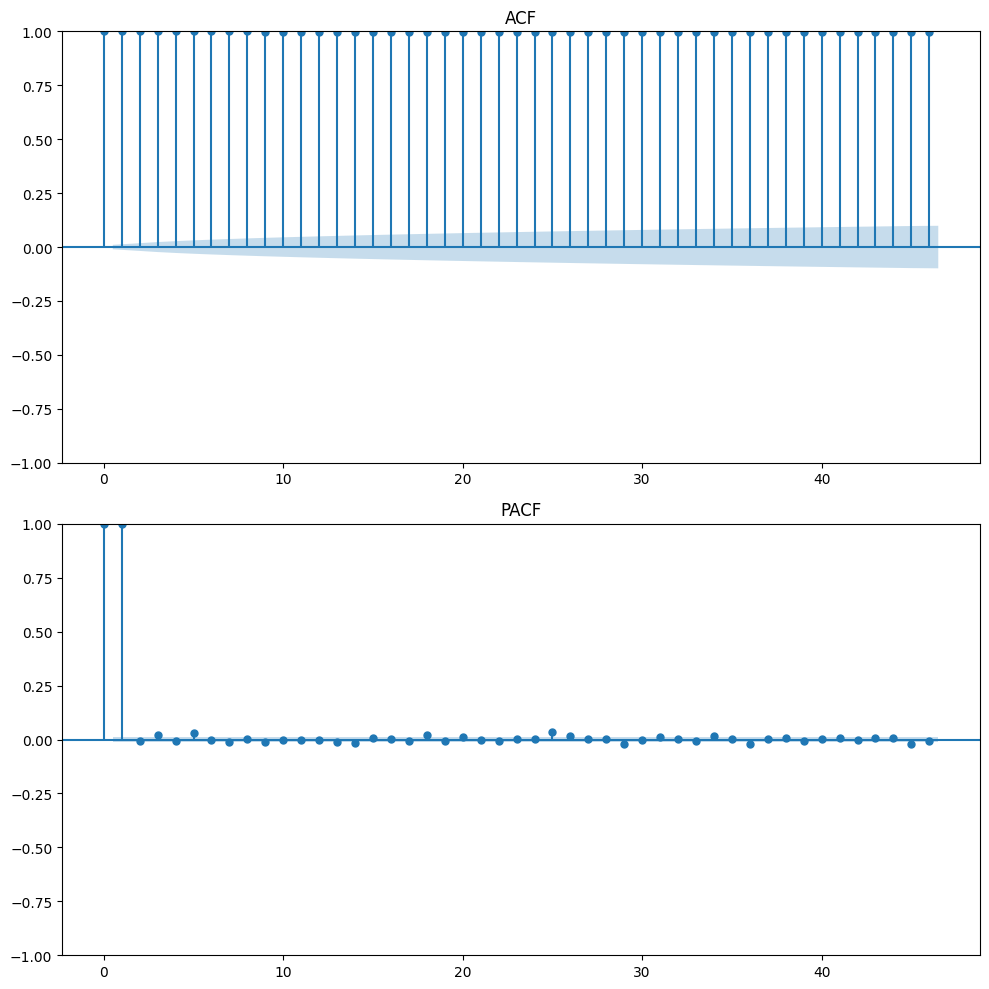

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plot_acf(new, ax=ax[0], title="ACF")
plot_pacf(new, ax=ax[1], title="PACF")

plt.savefig('ACF and PACF')
plt.tight_layout()

plt.show()

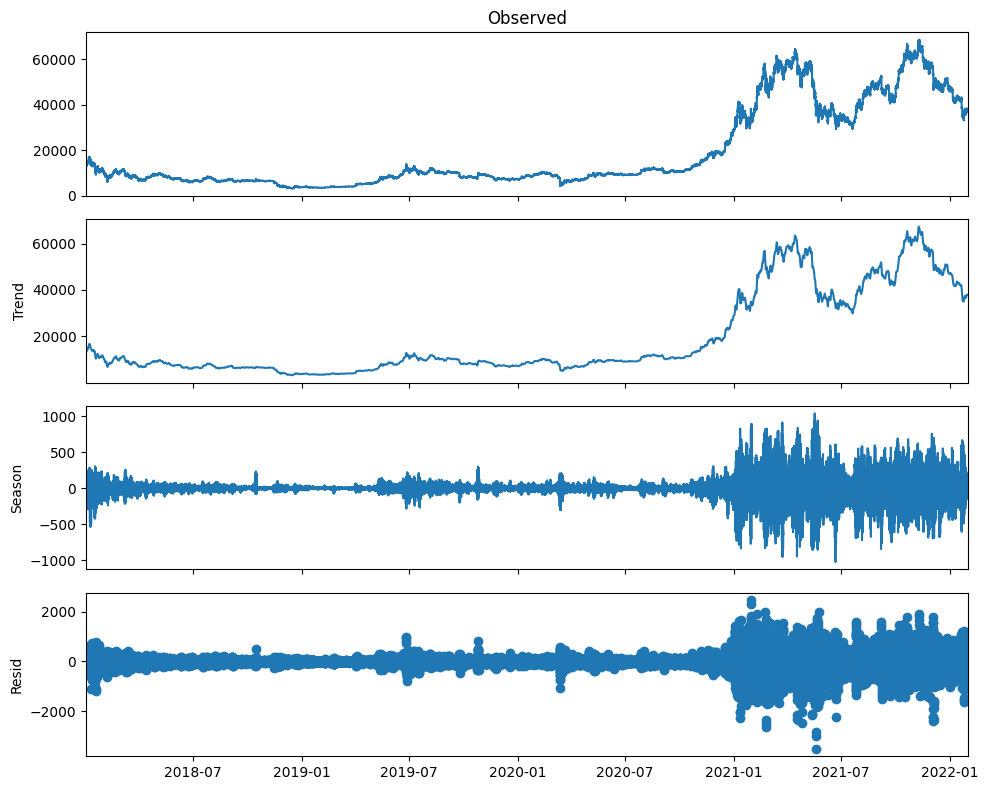

In [ ]:
stl = STL(new)
fig = stl.fit().plot()
fig.set_size_inches(10, 8)

plt.tight_layout()
plt.savefig('Seasonal decomposition')
plt.show()

# No apparent seasonality observed, both from the PACF plot
# and the fact that trend is almost identical to the observed data

In [ ]:
test_stationarity(stl.fit().seasonal)
test_stationarity(stl.fit().resid)

Stationary data!
Stationary data!


0.0

In [ ]:
import shutup
shutup.please()

aic = [["MA/AR", "0", "1", "2", "3"],
       ["0", None, None, None, None],
       ["1", None, None, None, None],
       ["2", None, None, None, None]]

new_train, new_test = new[:int(0.9*len(new))], new[int(0.9*len(new)):]
stationary_col = np.diff(new.close)

stationary_data = new.iloc[1:]
stationary_data['Differenced'] = stationary_col
stationary_data.drop(['close'], axis=1, inplace=True)
stationary_train, stationary_test = stationary_data[1:int(0.9*len(new))], stationary_data[int(0.9*len(new)):]

## **Trying to fit a basic Time Series model on the differenced stationary data**

In [ ]:
for i in range(3):
    for j in range(4):
        a = ARIMA(stationary_train, order=(i, 0, j), seasonal_order=(0, 0, 0, 0)) #no seasonality in the data
        result = a.fit()
        aic[i+1][j+1] = result.aic

In [ ]:
from prettytable import PrettyTable

table_aic = aic[1:]
headers_aic = aic[0]

x = PrettyTable()
x.field_names = headers_aic
for row in table_aic[:-1]:
    x.add_row(row)
x.add_row([table_aic[-1][0], table_aic[-1][1], table_aic[-1][2], f'\x1b[6;37;40m{table_aic[-1][3]}\x1b[0m', table_aic[-1][4]])

print('Akaike Information Criterions:\n', x)

Akaike Information Criterions:
 +-------+--------------------+-------------------+--------------------+--------------------+
| MA/AR |         0          |         1         |         2          |         3          |
+-------+--------------------+-------------------+--------------------+--------------------+
|   0   | 431661.57732445985 | 431660.4062712174 | 431640.3991706522  | 431642.13748988707 |
|   1   | 431660.56141670246 | 431642.7672508065 | 431628.2499700096  | 431630.16534426267 |
|   2   | 431642.39743211446 | 431627.9817726457 | 431622.09805351094 |  431623.185325693  |
+-------+--------------------+-------------------+--------------------+--------------------+


In [ ]:
from pmdarima import auto_arima

model = auto_arima(stationary_data['Differenced'], seasonal=True)
model.order, model.seasonal_order

#So now we have two different models to check: ARIMA(2, 0, 2) and ARIMA(3, 0, 3). Note that the
# AIC values are pretty close to each other

((3, 0, 3), (0, 0, 0, 0))

In [ ]:
model202 = ARIMA(stationary_train, order=(2, 0, 2), seasonal_order=(0, 0, 0, 0)) # no seasonality in the data
result202 = model202.fit()
predictions202 = result202.predict(start=0, end=len(new) - 1)

model303 = ARIMA(stationary_train, order=(4, 0, 4), seasonal_order=(0, 0, 0, 0)) # no seasonality in the data
result303 = model303.fit()
predictions303 = result303.predict(start=0, end=len(new) - 1)

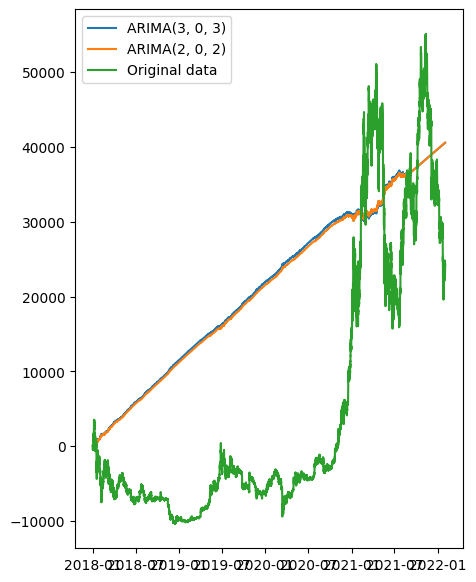

In [ ]:
plt.figure(figsize=(5, 7))
plt.plot(np.cumsum(predictions303), label='ARIMA(3, 0, 3)')
plt.plot(np.cumsum(predictions202), label='ARIMA(2, 0, 2)')
plt.plot(np.cumsum(stationary_data), label='Original data')
plt.legend()
plt.show()

## **Using the Holt-Winters Exponential Smoothing to try prediction**

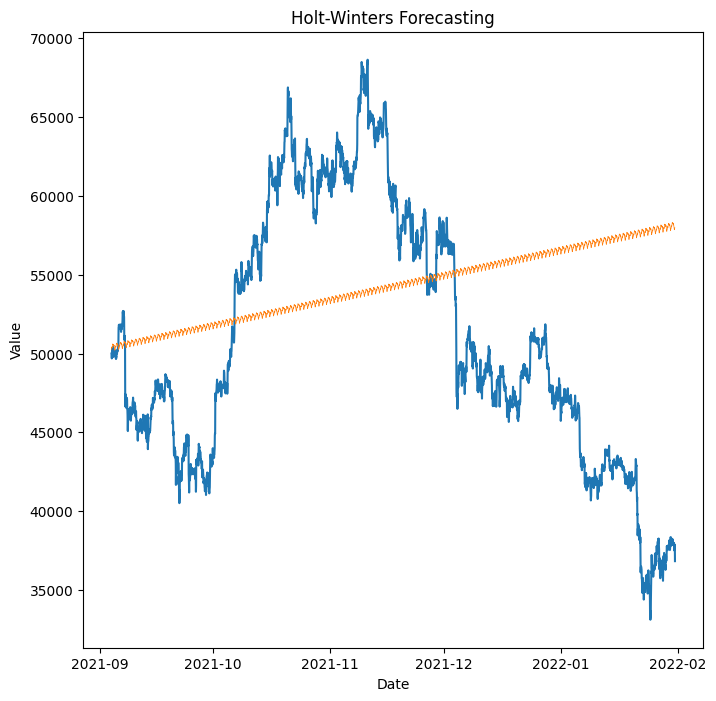

In [ ]:
hw = ExponentialSmoothing(new[:int(0.9*len(new))], trend='add', seasonal='mul', seasonal_periods=24)
fit_model = hw.fit(optimized=True)
forecast = fit_model.forecast(int(0.1*len(new)))
plt.figure(figsize=(8,8))
plt.plot(new[int(0.9*len(new) + 1):])
plt.plot(forecast, label='Holt-Winters Forecast', linewidth=0.5)
plt.title('Holt-Winters Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()